In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW,  get_scheduler
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from datasets import load_dataset
import pandas as pd

hyperparameters = {
    'learning_rate': 2e-5,
    'batch_size': 64,
    'num_epochs': 8,
    'dropout_rate': 0.3,
    'weight_decay': 1e-4,
    'warmup_steps': 100,
    'lr_scheduler': 'linear',
    'optimizer': 'AdamW'
}

def train_bert(dataset, tuning = False, param = hyperparameters):
  print(param)
  # Extract train and test sets
  train_data = dataset['train']
  test_data = dataset['test']

  # Convert datasets to Pandas DataFrame for easier manipulation
  train_df = pd.DataFrame({'text': train_data['text'], 'label': train_data['label']})
  test_df = pd.DataFrame({'text': test_data['text'], 'label': test_data['label']})

  # Preprocess the data
  train_df['text'] = train_df['text'].apply(lambda x: str(x))
  test_df['text'] = test_df['text'].apply(lambda x: str(x))

  # Load pre-trained BERT model and tokenizer
  model_name = 'bert-base-uncased'
  tokenizer = BertTokenizer.from_pretrained(model_name)

  dropout_rate = param['dropout_rate']

  # Load pre-trained BERT model and tokenizer
  model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(train_df['label'].unique()), hidden_dropout_prob=dropout_rate)

  # Tokenize and format the data with attention_mask
  def tokenize_data(text, max_len=128):
      tokens = tokenizer.encode_plus(text, max_length=max_len, padding='max_length', truncation=True, return_tensors='pt', return_attention_mask=True)
      return tokens

  print('Tokenizing...')
  X_train_tokens = torch.cat([tokenize_data(text)['input_ids'] for text in train_df['text']])
  X_test_tokens = torch.cat([tokenize_data(text)['input_ids'] for text in test_df['text']])
  attention_mask_train = torch.cat([tokenize_data(text)['attention_mask'] for text in train_df['text']])
  attention_mask_test = torch.cat([tokenize_data(text)['attention_mask'] for text in test_df['text']])

  # Create DataLoader for training and testing data
  batch_size = param['batch_size']
  train_dataset = TensorDataset(X_train_tokens, attention_mask_train, torch.tensor(train_df['label'].values))
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  test_dataset = TensorDataset(X_test_tokens, attention_mask_test, torch.tensor(test_df['label'].values))
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  epochs = param['num_epochs']
  lr = param['learning_rate']
  weight_decay = param['weight_decay']

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  print('Training start...')
  warmup_steps = param['warmup_steps']

  # Optimizer and Scheduler
  if param['optimizer'] == 'AdamW':
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
  elif param['optimizer'] == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

  scheduler = get_scheduler(
                            param['lr_scheduler'],
                            optimizer,
                            num_warmup_steps=warmup_steps,
                            num_training_steps=len(train_dataloader) * epochs
                        )
  train_loss = []
  val_loss = []
  train_acc = []
  val_acc = []

  for epoch in range(epochs):
      model.train()
      total_loss = 0
      total_val_loss = 0

      all_preds = []
      all_labels = []
      for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}'):
        inputs, attention_mask, labels = batch
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        _, preds = torch.max(outputs.logits, 1)
        all_preds.extend(preds.cpu().numpy())

        # Store true labels
        all_labels.extend(labels.cpu().numpy())

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

      average_loss = total_loss / len(train_dataloader)
      train_loss.append(average_loss)
      accuracy = accuracy_score(all_labels, all_preds)
      train_acc.append(accuracy)
      print(f'Epoch {epoch + 1}/{epochs}, Train, Loss: {average_loss:.4f}, Acc: {accuracy:.4f}')

      # Evaluation
      model.eval()
      all_preds = []
      with torch.no_grad():
          for batch in tqdm(test_dataloader, desc='Evaluating'):
              inputs, attention_mask, labels = batch
              inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

              outputs = model(inputs, attention_mask=attention_mask, labels=labels)
              _, preds = torch.max(outputs.logits, 1)
              all_preds.extend(preds.cpu().numpy())
              loss = outputs.loss
              total_val_loss += loss.item()

      # Evaluate the model
      average_loss = total_val_loss / len(test_dataloader)
      val_loss.append(average_loss)
      accuracy = accuracy_score(test_df['label'].values, all_preds)
      val_acc.append(accuracy)
      print(f'Epoch {epoch + 1}/{epochs}, Val, Loss: {average_loss:.4f}, Acc: {accuracy:.4f}')

  # Print classification report
  if not tuning:
    print('Classification Report:\n', classification_report(test_df['label'].values, all_preds))

  return train_loss, val_loss, train_acc, val_acc

# AG

## Few

In [ ]:
import random
from datasets import Dataset, DatasetDict

def generate_few_shot_dataset(dataset, num_samples_per_class):
    few_shot_samples = []

    for class_label in set(dataset['train']['label']):
        class_indices = [i for i, label in enumerate(dataset['train']['label']) if label == class_label]
        sampled_indices = random.sample(class_indices, min(num_samples_per_class, len(class_indices)))
        few_shot_samples.extend([dataset['train'][i] for i in sampled_indices])

    few_shot_dataset = Dataset.from_dict({'text': [item['text'] for item in few_shot_samples],
                                               'label': [item['label'] for item in few_shot_samples]})

    combined_dataset_dict = DatasetDict({
        'train': few_shot_dataset,
        'test': dataset['test']
    })

    return combined_dataset_dict

In [ ]:
dataset = load_dataset("ag_news")
acc_list = []

for num_samples in [5, 10, 25, 50, 75, 100, 125, 150, 175, 200]:
  print(f'Training with {num_samples} samples per class')

  few_shot_dataset = generate_few_shot_dataset(dataset, num_samples)
  acc = max(train_bert(few_shot_dataset)[3])
  acc_list.append(acc)

Training with 5 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/5: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Epoch 1/5, Loss: 1.4089


Epoch 2/5: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch 2/5, Loss: 1.4062


Epoch 3/5: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch 3/5, Loss: 1.3667


Epoch 4/5: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch 4/5, Loss: 1.3071


Epoch 5/5: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch 5/5, Loss: 1.2077


Evaluating: 100%|██████████| 119/119 [00:49<00:00,  2.41it/s]



Accuracy: 0.42
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.30      0.44      1900
           1       0.70      0.28      0.40      1900
           2       0.42      0.63      0.51      1900
           3       0.28      0.49      0.36      1900

    accuracy                           0.42      7600
   macro avg       0.55      0.42      0.43      7600
weighted avg       0.55      0.42      0.43      7600

Training with 10 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/5: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Epoch 1/5, Loss: 1.5043


Epoch 2/5: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch 2/5, Loss: 1.4083


Epoch 3/5: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch 3/5, Loss: 1.3307


Epoch 4/5: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch 4/5, Loss: 1.2883


Epoch 5/5: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch 5/5, Loss: 1.2560


Evaluating: 100%|██████████| 119/119 [00:51<00:00,  2.31it/s]



Accuracy: 0.37
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.09      0.15      1900
           1       0.98      0.09      0.16      1900
           2       0.38      0.60      0.47      1900
           3       0.34      0.71      0.46      1900

    accuracy                           0.37      7600
   macro avg       0.52      0.37      0.31      7600
weighted avg       0.52      0.37      0.31      7600

Training with 25 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/5: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Epoch 1/5, Loss: 1.4097


Epoch 2/5: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 2/5, Loss: 1.3159


Epoch 3/5: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 3/5, Loss: 1.2845


Epoch 4/5: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 4/5, Loss: 1.2046


Epoch 5/5: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 5/5, Loss: 1.1443


Evaluating: 100%|██████████| 119/119 [00:53<00:00,  2.23it/s]



Accuracy: 0.62
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.85      0.63      1900
           1       0.93      0.62      0.74      1900
           2       0.57      0.54      0.56      1900
           3       0.71      0.48      0.57      1900

    accuracy                           0.62      7600
   macro avg       0.68      0.62      0.63      7600
weighted avg       0.68      0.62      0.63      7600

Training with 50 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/5: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Epoch 1/5, Loss: 1.4137


Epoch 2/5: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Epoch 2/5, Loss: 1.3024


Epoch 3/5: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Epoch 3/5, Loss: 1.1668


Epoch 4/5: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Epoch 4/5, Loss: 1.1014


Epoch 5/5: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Epoch 5/5, Loss: 0.9827


Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.20it/s]



Accuracy: 0.72
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.88      0.76      1900
           1       0.92      0.79      0.85      1900
           2       0.81      0.35      0.49      1900
           3       0.62      0.87      0.72      1900

    accuracy                           0.72      7600
   macro avg       0.75      0.72      0.71      7600
weighted avg       0.75      0.72      0.71      7600

Training with 75 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/5: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 1/5, Loss: 1.3626


Epoch 2/5: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 2/5, Loss: 1.2086


Epoch 3/5: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 3/5, Loss: 0.9938


Epoch 4/5: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 4/5, Loss: 0.8032


Epoch 5/5: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 5/5, Loss: 0.6596


Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.17it/s]



Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1900
           1       0.95      0.92      0.94      1900
           2       0.76      0.80      0.78      1900
           3       0.83      0.75      0.79      1900

    accuracy                           0.84      7600
   macro avg       0.84      0.84      0.84      7600
weighted avg       0.84      0.84      0.84      7600

Training with 100 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/5: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Epoch 1/5, Loss: 1.3470


Epoch 2/5: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Epoch 2/5, Loss: 1.1429


Epoch 3/5: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Epoch 3/5, Loss: 0.9112


Epoch 4/5: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch 4/5, Loss: 0.7156


Epoch 5/5: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch 5/5, Loss: 0.5169


Evaluating: 100%|██████████| 119/119 [00:55<00:00,  2.15it/s]



Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      1900
           1       0.95      0.97      0.96      1900
           2       0.80      0.86      0.83      1900
           3       0.87      0.80      0.83      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Training with 125 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/5: 100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Epoch 1/5, Loss: 1.3380


Epoch 2/5: 100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Epoch 2/5, Loss: 1.0434


Epoch 3/5: 100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


Epoch 3/5, Loss: 0.7602


Epoch 4/5: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


Epoch 4/5, Loss: 0.5589


Epoch 5/5: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


Epoch 5/5, Loss: 0.4061


Evaluating: 100%|██████████| 119/119 [00:55<00:00,  2.14it/s]



Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89      1900
           1       0.96      0.98      0.97      1900
           2       0.80      0.87      0.83      1900
           3       0.87      0.82      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Training with 150 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/5: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 1/5, Loss: 1.3076


Epoch 2/5: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Epoch 2/5, Loss: 1.0287


Epoch 3/5: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Epoch 3/5, Loss: 0.7646


Epoch 4/5: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Epoch 4/5, Loss: 0.5291


Epoch 5/5: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Epoch 5/5, Loss: 0.3799


Evaluating: 100%|██████████| 119/119 [00:55<00:00,  2.14it/s]



Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      1900
           1       0.96      0.98      0.97      1900
           2       0.86      0.76      0.81      1900
           3       0.80      0.91      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Training with 175 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/5: 100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


Epoch 1/5, Loss: 1.3270


Epoch 2/5: 100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


Epoch 2/5, Loss: 1.0259


Epoch 3/5: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


Epoch 3/5, Loss: 0.7324


Epoch 4/5: 100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


Epoch 4/5, Loss: 0.5140


Epoch 5/5: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


Epoch 5/5, Loss: 0.3359


Evaluating: 100%|██████████| 119/119 [00:55<00:00,  2.14it/s]



Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90      1900
           1       0.95      0.98      0.96      1900
           2       0.82      0.85      0.84      1900
           3       0.86      0.86      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Training with 200 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/5: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it]


Epoch 1/5, Loss: 1.2697


Epoch 2/5: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 2/5, Loss: 0.8714


Epoch 3/5: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 3/5, Loss: 0.5614


Epoch 4/5: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 4/5, Loss: 0.3439


Epoch 5/5: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


Epoch 5/5, Loss: 0.2280


Evaluating: 100%|██████████| 119/119 [00:55<00:00,  2.14it/s]


Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      1900
           1       0.95      0.98      0.96      1900
           2       0.84      0.84      0.84      1900
           3       0.88      0.84      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



## Parameter Searching

In [ ]:
import random
from datasets import Dataset, DatasetDict

def generate_few_shot_dataset(dataset, num_samples_per_class, num_samples_per_class_test):
    few_shot_samples = []
    few_shot_samples_test = []

    for class_label in set(dataset['train']['label']):
        class_indices = [i for i, label in enumerate(dataset['train']['label']) if label == class_label]
        sampled_indices = random.sample(class_indices, min(num_samples_per_class, len(class_indices)))
        few_shot_samples.extend([dataset['train'][i] for i in sampled_indices])

    few_shot_dataset = Dataset.from_dict({'text': [item['text'] for item in few_shot_samples],
                                          'label': [item['label'] for item in few_shot_samples]})

    for class_label in set(dataset['test']['label']):
        class_indices = [i for i, label in enumerate(dataset['test']['label']) if label == class_label]
        sampled_indices = random.sample(class_indices, min(num_samples_per_class_test, len(class_indices)))
        few_shot_samples_test.extend([dataset['test'][i] for i in sampled_indices])

    few_shot_test = Dataset.from_dict({'text': [item['text'] for item in few_shot_samples_test],
                                       'label': [item['label'] for item in few_shot_samples_test]})


    combined_dataset_dict = DatasetDict({
        'train': few_shot_dataset,
        'test': few_shot_test
    })

    return combined_dataset_dict

In [3]:
parameter_grid = {
    'learning_rate': [1e-5, 2e-5, 5e-5],
    'batch_size': [32, 64],
    'num_epochs': [5],
    'dropout_rate': [0.1, 0.3],
    'weight_decay': [1e-4],
    'warmup_steps': [0, 500],
    'lr_scheduler': ['linear', 'cosine'],
    'optimizer': ['AdamW']
}

import itertools
all_param_combinations = list(itertools.product(*parameter_grid.values()))

In [ ]:
dataset = load_dataset("ag_news")
tune_dataset = generate_few_shot_dataset(dataset, 250, 1000)
acc_list = []

# Generate all combinations of hyperparameters
for params in all_param_combinations:
    print(len(acc_list)+1)
    hyperparameters = dict(zip(parameter_grid.keys(), params))
    acc = max(train_bert(tune_dataset, tuning = True, param = hyperparameters)[3])
    acc_list.append(acc)

In [ ]:
acc_list

[0.87175,
 0.88975,
 0.73375,
 0.7685,
 0.876,
 0.8445,
 0.629,
 0.66775,
 0.85925,
 0.79675,
 0.35175,
 0.472,
 0.80325,
 0.8185,
 0.3985,
 0.40825,
 0.8965,
 0.89475,
 0.86775,
 0.858,
 0.88825,
 0.88375,
 0.8435,
 0.80525,
 0.88675,
 0.88975,
 0.49,
 0.61325,
 0.8615,
 0.875,
 0.572,
 0.558,
 0.901,
 0.897,
 0.8875,
 0.89225,
 0.89925,
 0.8995,
 0.882,
 0.87925,
 0.89875,
 0.9,
 0.83325,
 0.8405,
 0.89725,
 0.893,
 0.61575,
 0.72725]

In [4]:
final_output = [0.87175, 0.88975, 0.73375, 0.7685, 0.876, 0.8445, 0.629, 0.66775,
                0.85925, 0.79675, 0.35175, 0.472, 0.80325, 0.8185, 0.3985, 0.40825,
                0.8965, 0.89475, 0.86775, 0.858, 0.88825, 0.88375, 0.8435, 0.80525,
                0.88675, 0.88975, 0.49, 0.61325, 0.8615, 0.875, 0.572, 0.558, 0.901,
                0.897, 0.8875, 0.89225, 0.89925, 0.8995, 0.882, 0.87925, 0.89875, 0.9,
                0.83325, 0.8405, 0.89725, 0.893, 0.61575, 0.72725]

In [ ]:
final_output = acc_list

In [5]:
final = []
for i, param in enumerate(all_param_combinations):
  param = list(param)
  param.append(final_output[i])
  final.append(param)

In [6]:
columns = [
    'learning_rate', 'batch_size', 'num_epochs', 'dropout_rate',
    'weight_decay', 'warmup_steps', 'scheduler_type', 'optimizer', 'final_output'
]

# Convert the list of lists into a DataFrame
df = pd.DataFrame(final, columns=columns)
df_sorted = df.sort_values(by='final_output', ascending=False)
df_sorted.head()

,learning_rate,batch_size,num_epochs,dropout_rate,weight_decay,warmup_steps,scheduler_type,optimizer,final_output
32,0.00005,32,5,0.1,0.0001,0,linear,AdamW,0.90100
41,0.00005,64,5,0.1,0.0001,0,cosine,AdamW,0.90000
37,0.00005,32,5,0.3,0.0001,0,cosine,AdamW,0.89950
36,0.00005,32,5,0.3,0.0001,0,linear,AdamW,0.89925
40,0.00005,64,5,0.1,0.0001,0,linear,AdamW,0.89875


## Train

In [ ]:
dataset = load_dataset("ag_news")
new_dataset = generate_few_shot_dataset(dataset, 15000, 1500)
new_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 6000
    })
})

In [ ]:
hyperparameters = dict(zip(parameter_grid.keys(), all_param_combinations[df_sorted.index[0]]))
hyperparameters['num_epochs'] = 8
train_loss, val_loss, train_acc, val_acc = train_bert(new_dataset, tuning = False, param = hyperparameters)

{'learning_rate': 5e-05, 'batch_size': 32, 'num_epochs': 8, 'dropout_rate': 0.1, 'weight_decay': 0.0001, 'warmup_steps': 0, 'lr_scheduler': 'linear', 'optimizer': 'AdamW'}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/8: 100%|██████████| 1875/1875 [19:25<00:00,  1.61it/s]


Epoch 1/8, Train, Loss: 0.2402, Acc: 0.9193


Evaluating: 100%|██████████| 188/188 [00:40<00:00,  4.67it/s]


Epoch 1/8, Val, Loss: 0.1984, Acc: 0.9332


Epoch 2/8: 100%|██████████| 1875/1875 [19:25<00:00,  1.61it/s]


Epoch 2/8, Train, Loss: 0.1350, Acc: 0.9540


Evaluating: 100%|██████████| 188/188 [00:40<00:00,  4.67it/s]


Epoch 2/8, Val, Loss: 0.1936, Acc: 0.9372


Epoch 3/8: 100%|██████████| 1875/1875 [19:25<00:00,  1.61it/s]


Epoch 3/8, Train, Loss: 0.0841, Acc: 0.9714


Evaluating: 100%|██████████| 188/188 [00:40<00:00,  4.65it/s]


Epoch 3/8, Val, Loss: 0.2008, Acc: 0.9393


Epoch 4/8: 100%|██████████| 1875/1875 [19:25<00:00,  1.61it/s]


Epoch 4/8, Train, Loss: 0.0475, Acc: 0.9843


Evaluating: 100%|██████████| 188/188 [00:40<00:00,  4.68it/s]


Epoch 4/8, Val, Loss: 0.2323, Acc: 0.9375


Epoch 5/8: 100%|██████████| 1875/1875 [19:25<00:00,  1.61it/s]


Epoch 5/8, Train, Loss: 0.0257, Acc: 0.9917


Evaluating: 100%|██████████| 188/188 [00:40<00:00,  4.65it/s]


Epoch 5/8, Val, Loss: 0.2811, Acc: 0.9402


Epoch 6/8: 100%|██████████| 1875/1875 [19:25<00:00,  1.61it/s]


Epoch 6/8, Train, Loss: 0.0138, Acc: 0.9956


Evaluating: 100%|██████████| 188/188 [00:40<00:00,  4.64it/s]


Epoch 6/8, Val, Loss: 0.3072, Acc: 0.9395


Epoch 7/8: 100%|██████████| 1875/1875 [19:25<00:00,  1.61it/s]


Epoch 7/8, Train, Loss: 0.0060, Acc: 0.9981


Evaluating: 100%|██████████| 188/188 [00:40<00:00,  4.67it/s]


Epoch 7/8, Val, Loss: 0.3409, Acc: 0.9397


Epoch 8/8: 100%|██████████| 1875/1875 [19:25<00:00,  1.61it/s]


Epoch 8/8, Train, Loss: 0.0035, Acc: 0.9989


Evaluating: 100%|██████████| 188/188 [00:40<00:00,  4.67it/s]

Epoch 8/8, Val, Loss: 0.3509, Acc: 0.9410
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      1500
           1       0.98      0.99      0.99      1500
           2       0.92      0.90      0.91      1500
           3       0.91      0.92      0.91      1500

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



In [ ]:
dataset = load_dataset("ag_news")
hyperparameters = dict(zip(parameter_grid.keys(), all_param_combinations[df_sorted.index[0]]))
train_loss, val_loss, train_acc, val_acc = train_bert(dataset, tuning = False, param = hyperparameters)
train_loss, val_loss, train_acc, val_acc

{'learning_rate': 5e-05, 'batch_size': 32, 'num_epochs': 5, 'dropout_rate': 0.1, 'weight_decay': 0.0001, 'warmup_steps': 0, 'lr_scheduler': 'linear', 'optimizer': 'AdamW'}


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...
Training start...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 3750/3750 [40:37<00:00,  1.54it/s]


Epoch 1/5, Train, Loss: 0.2165, Acc: 0.9266


Evaluating: 100%|██████████| 238/238 [00:54<00:00,  4.34it/s]


Epoch 1/5, Val, Loss: 0.1757, Acc: 0.9420


Epoch 2/5: 100%|██████████| 3750/3750 [40:44<00:00,  1.53it/s]


Epoch 2/5, Train, Loss: 0.1270, Acc: 0.9563


Evaluating: 100%|██████████| 238/238 [00:54<00:00,  4.34it/s]


Epoch 2/5, Val, Loss: 0.1638, Acc: 0.9430


Epoch 3/5: 100%|██████████| 3750/3750 [40:45<00:00,  1.53it/s]


Epoch 3/5, Train, Loss: 0.0770, Acc: 0.9732


Evaluating: 100%|██████████| 238/238 [00:54<00:00,  4.33it/s]


Epoch 3/5, Val, Loss: 0.1896, Acc: 0.9407


Epoch 4/5: 100%|██████████| 3750/3750 [40:45<00:00,  1.53it/s]


Epoch 4/5, Train, Loss: 0.0388, Acc: 0.9865


Evaluating: 100%|██████████| 238/238 [00:54<00:00,  4.35it/s]


Epoch 4/5, Val, Loss: 0.2280, Acc: 0.9455


Epoch 5/5: 100%|██████████| 3750/3750 [40:47<00:00,  1.53it/s]


Epoch 5/5, Train, Loss: 0.0159, Acc: 0.9947


Evaluating: 100%|██████████| 238/238 [00:54<00:00,  4.35it/s]

Epoch 5/5, Val, Loss: 0.2605, Acc: 0.9462
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      1900
           1       0.99      0.99      0.99      1900
           2       0.92      0.91      0.92      1900
           3       0.93      0.92      0.92      1900

    accuracy                           0.95      7600
   macro avg       0.95      0.95      0.95      7600
weighted avg       0.95      0.95      0.95      7600



([0.2164699054899315,
  0.12699545423351227,
  0.07702122309474896,
  0.03882933543357843,
  0.01594797527352348],
 [0.17572609857781282,
  0.16383484964251144,
  0.1896371843274722,
  0.2280373311681798,
  0.2605161054146441],
 [0.9265583333333334,
  0.9562583333333333,
  0.973225,
  0.9865166666666667,
  0.9946833333333334],
 [0.9419736842105263,
  0.9430263157894737,
  0.9406578947368421,
  0.9455263157894737,
  0.9461842105263157])

In [ ]:
train_loss, val_loss, train_acc, val_acc = [0.2164699054899315,
  0.12699545423351227,
  0.07702122309474896,
  0.03882933543357843,
  0.01594797527352348], [0.17572609857781282,
  0.16383484964251144,
  0.1896371843274722,
  0.2280373311681798,
  0.2605161054146441], [0.9265583333333334,
  0.9562583333333333,
  0.973225,
  0.9865166666666667,
  0.9946833333333334], [0.9419736842105263,
  0.9430263157894737,
  0.9406578947368421,
  0.9455263157894737,
  0.9461842105263157]

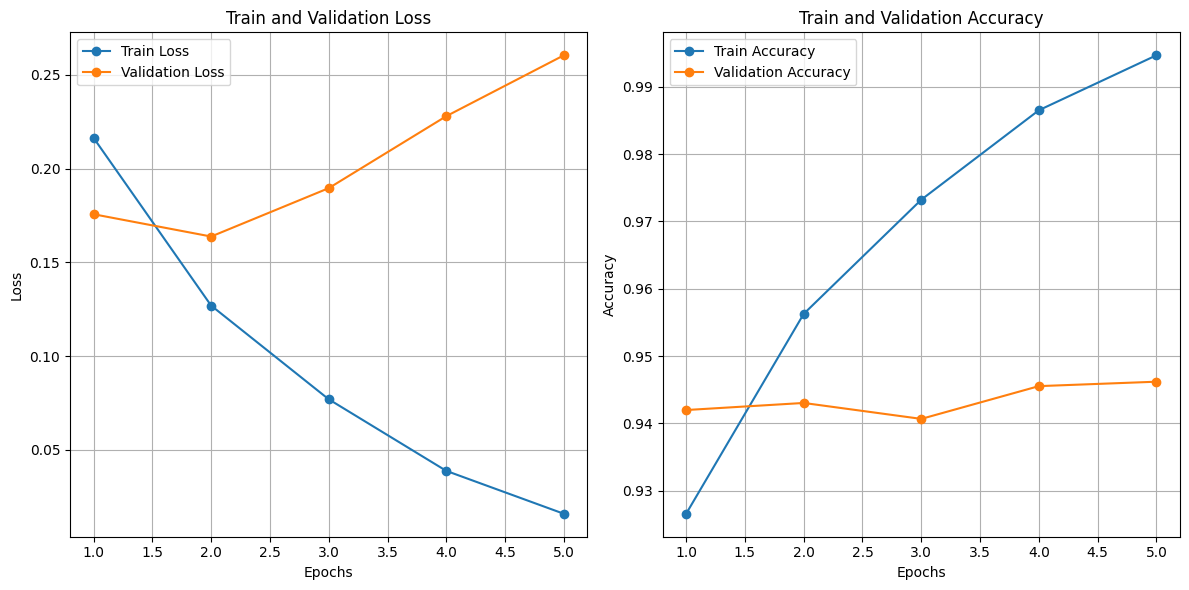

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1,len(train_loss)+1), train_loss, label='Train Loss', marker='o')
plt.plot(range(1,len(train_loss)+1), val_loss, label='Validation Loss', marker='o')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting train and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(list(range(1,len(train_loss)+1)), train_acc, label='Train Accuracy', marker='o')
plt.plot(list(range(1,len(train_loss)+1)), val_acc, label='Validation Accuracy', marker='o')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

# Gzip+BERT

In [7]:
import gzip
# Update as Needed
dataset_name = 'AG News'
training_set = None
test_set = None

num_training_dps_per_class = 100
num_test_dps = 20

In [ ]:
if dataset_name == 'AG News':
    full_training_set = new_dataset['train']
    training_dps_list = []
    for label in set(full_training_set['label']):
        df_agnews_training = full_training_set.to_pandas()
        df_agnews_training = df_agnews_training[df_agnews_training['label'] == label]
        training_dps_list.append(df_agnews_training.sample(n=num_training_dps_per_class))
    training_set_df = pd.concat(training_dps_list)
    training_set = training_set_df.to_dict('records')

    full_test_set = new_dataset['test']
    df_agnews_test = full_test_set.to_pandas()
    test_set = (df_agnews_test.sample(n=num_test_dps)).to_dict('records')

NameError: ignored

In [8]:
full = True
dataset = load_dataset("ag_news")
if full == True:
  training_set = dataset['train'].to_pandas().to_dict('records')
  test_set = dataset['test'].to_pandas().to_dict('records')

processed_training_set = []
processed_test_set = []
for training_data in training_set:
    compressed_training_data_length = len(gzip.compress(training_data['text'].encode('UTF-7'), compresslevel=9))
    new_training_data = {'text': training_data['text'] + ' Gzip compressed length: ' + str(compressed_training_data_length), 'label': training_data['label']}
    processed_training_set.append(new_training_data)

for test_data in test_set:
    compressed_test_data_length = len(gzip.compress(test_data['text'].encode('UTF-7'), compresslevel=9))
    new_test_data = {'text': test_data['text'] + ' Gzip compressed length: ' + str(compressed_test_data_length), 'label': test_data['label']}
    processed_test_set.append(new_test_data)

print(processed_training_set[0])
print(processed_test_set[0])

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again. Gzip compressed length: 136", 'label': 2}
{'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul. Gzip compressed length: 134", 'label': 2}


In [9]:
import random
from datasets import Dataset, DatasetDict

gzip_dataset = DatasetDict({
        'train': Dataset.from_dict({'text': [item['text'] for item in processed_training_set],
                   'label': [item['label'] for item in processed_training_set]}),
        'test': Dataset.from_dict({'text': [item['text'] for item in processed_test_set],
                   'label': [item['label'] for item in processed_test_set]})
    })

In [10]:
gzip_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [11]:
hyperparameters = dict(zip(parameter_grid.keys(), all_param_combinations[df_sorted.index[0]]))
train_loss, val_loss, train_acc, val_acc = train_bert(gzip_dataset, param = hyperparameters)

{'learning_rate': 5e-05, 'batch_size': 32, 'num_epochs': 5, 'dropout_rate': 0.1, 'weight_decay': 0.0001, 'warmup_steps': 0, 'lr_scheduler': 'linear', 'optimizer': 'AdamW'}


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...
Training start...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5:   0%|          | 9/3750 [07:17<50:34:20, 48.67s/it]


KeyboardInterrupt: ignored

In [ ]:
train_loss, val_loss, train_acc, val_acc

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1,len(train_loss)+1), train_loss, label='Train Loss', marker='o')
plt.plot(range(1,len(train_loss)+1), val_loss, label='Validation Loss', marker='o')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting train and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(list(range(1,len(train_loss)+1)), train_acc, label='Train Accuracy', marker='o')
plt.plot(list(range(1,len(train_loss)+1)), val_acc, label='Validation Accuracy', marker='o')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

# Sogou

In [ ]:
sogou_news_dataset = load_dataset("sogou_news")
sogou_news_dataset = sogou_news_dataset.rename_column('content','text')

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/450000 [00:00<?, ? examples/s]

In [ ]:
sogou_news_dataset

DatasetDict({
    test: Dataset({
        features: ['title', 'text', 'label'],
        num_rows: 60000
    })
    train: Dataset({
        features: ['title', 'text', 'label'],
        num_rows: 450000
    })
})

In [ ]:
import random
from datasets import Dataset, DatasetDict

def generate_few_shot_dataset(dataset, num_samples_per_class, num_samples_per_class_test):
    few_shot_samples = []
    few_shot_samples_test = []

    for class_label in set(dataset['train']['label']):
        class_indices = [i for i, label in enumerate(dataset['train']['label']) if label == class_label]
        sampled_indices = random.sample(class_indices, min(num_samples_per_class, len(class_indices)))
        few_shot_samples.extend([dataset['train'][i] for i in sampled_indices])

    few_shot_dataset = Dataset.from_dict({'text': [item['text'] for item in few_shot_samples],
                                          'label': [item['label'] for item in few_shot_samples]})

    for class_label in set(dataset['test']['label']):
        class_indices = [i for i, label in enumerate(dataset['test']['label']) if label == class_label]
        sampled_indices = random.sample(class_indices, min(num_samples_per_class_test, len(class_indices)))
        few_shot_samples_test.extend([dataset['test'][i] for i in sampled_indices])

    few_shot_test = Dataset.from_dict({'text': [item['text'] for item in few_shot_samples_test],
                                       'label': [item['label'] for item in few_shot_samples_test]})


    combined_dataset_dict = DatasetDict({
        'train': few_shot_dataset,
        'test': few_shot_test
    })

    return combined_dataset_dict

In [ ]:
n_sogou_news_dataset = generate_few_shot_dataset(sogou_news_dataset, 10000, 500)

In [ ]:
n_sogou_news_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2500
    })
})

In [ ]:
train_bert(n_sogou_news_dataset)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/5: 100%|██████████| 782/782 [16:58<00:00,  1.30s/it]


Epoch 1/5, Loss: 0.6884


Epoch 2/5: 100%|██████████| 782/782 [17:09<00:00,  1.32s/it]


Epoch 2/5, Loss: 0.3849


Epoch 3/5: 100%|██████████| 782/782 [17:09<00:00,  1.32s/it]


Epoch 3/5, Loss: 0.3132


Epoch 4/5: 100%|██████████| 782/782 [17:09<00:00,  1.32s/it]


Epoch 4/5, Loss: 0.2623


Epoch 5/5: 100%|██████████| 782/782 [17:09<00:00,  1.32s/it]


Epoch 5/5, Loss: 0.2261


Evaluating: 100%|██████████| 40/40 [00:18<00:00,  2.16it/s]


Accuracy: 0.90
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       500
           1       0.77      0.92      0.84       500
           2       0.91      0.90      0.91       500
           3       0.92      0.89      0.91       500
           4       0.97      0.86      0.91       500

    accuracy                           0.90      2500
   macro avg       0.90      0.90      0.90      2500
weighted avg       0.90      0.90      0.90      2500



0.8964

## Few

We only take 1000 test examples. 60000 takes too long to tokenize.

In [ ]:
acc_list_sg = []

for num_samples in [5, 10, 25, 50, 75, 100, 125, 150, 175, 200]:
  print(f'Training with {num_samples} samples per class')
  few_shot_dataset = generate_few_shot_dataset(sogou_news_dataset, num_samples)
  acc = train_bert(few_shot_dataset)[0]
  acc_list_sg.append(acc)

Training with 5 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/3: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch 1/3, Loss: 1.6779


Epoch 2/3: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Epoch 2/3, Loss: 1.6000


Epoch 3/3: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch 3/3, Loss: 1.5678


Evaluating: 100%|██████████| 33/33 [00:06<00:00,  4.81it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.23
Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.10      0.13       205
           1       0.00      0.00      0.00       205
           2       0.34      0.09      0.15       205
           3       0.22      0.49      0.30       205
           4       0.23      0.45      0.31       205

    accuracy                           0.23      1025
   macro avg       0.20      0.23      0.18      1025
weighted avg       0.20      0.23      0.18      1025

Training with 10 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/3: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch 1/3, Loss: 1.6534


Epoch 2/3: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Epoch 2/3, Loss: 1.6172


Epoch 3/3: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch 3/3, Loss: 1.5597


Evaluating: 100%|██████████| 33/33 [00:07<00:00,  4.58it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.27
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       210
           1       0.36      0.06      0.10       210
           2       0.22      0.91      0.35       210
           3       0.39      0.10      0.16       210
           4       0.64      0.26      0.37       210

    accuracy                           0.27      1050
   macro avg       0.32      0.27      0.20      1050
weighted avg       0.32      0.27      0.20      1050

Training with 25 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/3: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch 1/3, Loss: 1.6465


Epoch 2/3: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch 2/3, Loss: 1.5848


Epoch 3/3: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Epoch 3/3, Loss: 1.5189


Evaluating: 100%|██████████| 36/36 [00:07<00:00,  4.55it/s]



Accuracy: 0.38
Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.06      0.09       225
           1       0.30      0.48      0.37       225
           2       0.36      0.58      0.44       225
           3       0.25      0.04      0.08       225
           4       0.56      0.72      0.63       225

    accuracy                           0.38      1125
   macro avg       0.33      0.38      0.32      1125
weighted avg       0.33      0.38      0.32      1125

Training with 50 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/3: 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


Epoch 1/3, Loss: 1.6299


Epoch 2/3: 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


Epoch 2/3, Loss: 1.5262


Epoch 3/3: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


Epoch 3/3, Loss: 1.4880


Evaluating: 100%|██████████| 40/40 [00:08<00:00,  4.52it/s]



Accuracy: 0.44
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.34      0.37       250
           1       0.41      0.26      0.32       250
           2       0.52      0.48      0.50       250
           3       0.28      0.42      0.34       250
           4       0.65      0.70      0.67       250

    accuracy                           0.44      1250
   macro avg       0.45      0.44      0.44      1250
weighted avg       0.45      0.44      0.44      1250

Training with 75 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/3: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Epoch 1/3, Loss: 1.6154


Epoch 2/3: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Epoch 2/3, Loss: 1.5074


Epoch 3/3: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch 3/3, Loss: 1.4326


Evaluating: 100%|██████████| 43/43 [00:09<00:00,  4.38it/s]



Accuracy: 0.35
Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.01      0.02       275
           1       0.24      0.98      0.39       275
           2       0.30      0.02      0.04       275
           3       0.66      0.11      0.18       275
           4       0.93      0.63      0.75       275

    accuracy                           0.35      1375
   macro avg       0.47      0.35      0.28      1375
weighted avg       0.47      0.35      0.28      1375

Training with 100 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/3: 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


Epoch 1/3, Loss: 1.6144


Epoch 2/3: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


Epoch 2/3, Loss: 1.5279


Epoch 3/3: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


Epoch 3/3, Loss: 1.4676


Evaluating: 100%|██████████| 47/47 [00:10<00:00,  4.45it/s]



Accuracy: 0.40
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.10      0.16       300
           1       0.29      0.79      0.42       300
           2       0.48      0.37      0.42       300
           3       0.30      0.09      0.13       300
           4       0.72      0.66      0.69       300

    accuracy                           0.40      1500
   macro avg       0.43      0.40      0.36      1500
weighted avg       0.43      0.40      0.36      1500

Training with 125 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/3: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Epoch 1/3, Loss: 1.5845


Epoch 2/3: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


Epoch 2/3, Loss: 1.4498


Epoch 3/3: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 3/3, Loss: 1.3622


Evaluating: 100%|██████████| 51/51 [00:11<00:00,  4.53it/s]



Accuracy: 0.46
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.84      0.44       325
           1       0.62      0.15      0.24       325
           2       0.65      0.42      0.51       325
           3       0.61      0.14      0.23       325
           4       0.71      0.77      0.74       325

    accuracy                           0.46      1625
   macro avg       0.58      0.46      0.43      1625
weighted avg       0.58      0.46      0.43      1625

Training with 150 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/3: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]


Epoch 1/3, Loss: 1.6012


Epoch 2/3: 100%|██████████| 24/24 [00:15<00:00,  1.52it/s]


Epoch 2/3, Loss: 1.4608


Epoch 3/3: 100%|██████████| 24/24 [00:15<00:00,  1.51it/s]


Epoch 3/3, Loss: 1.2918


Evaluating: 100%|██████████| 55/55 [00:11<00:00,  4.62it/s]



Accuracy: 0.57
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.47      0.52       350
           1       0.49      0.55      0.51       350
           2       0.69      0.54      0.61       350
           3       0.43      0.57      0.49       350
           4       0.79      0.73      0.76       350

    accuracy                           0.57      1750
   macro avg       0.59      0.57      0.58      1750
weighted avg       0.59      0.57      0.58      1750

Training with 175 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/3: 100%|██████████| 28/28 [00:17<00:00,  1.59it/s]


Epoch 1/3, Loss: 1.5590


Epoch 2/3: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]


Epoch 2/3, Loss: 1.4104


Epoch 3/3: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


Epoch 3/3, Loss: 1.2495


Evaluating: 100%|██████████| 59/59 [00:12<00:00,  4.69it/s]



Accuracy: 0.59
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.59      0.48       375
           1       0.49      0.48      0.49       375
           2       0.67      0.49      0.57       375
           3       0.67      0.75      0.71       375
           4       0.95      0.66      0.78       375

    accuracy                           0.59      1875
   macro avg       0.64      0.59      0.60      1875
weighted avg       0.64      0.59      0.60      1875

Training with 200 samples per class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training start...


Epoch 1/3: 100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


Epoch 1/3, Loss: 1.5887


Epoch 2/3: 100%|██████████| 32/32 [00:21<00:00,  1.51it/s]


Epoch 2/3, Loss: 1.4350


Epoch 3/3: 100%|██████████| 32/32 [00:20<00:00,  1.56it/s]


Epoch 3/3, Loss: 1.3124


Evaluating: 100%|██████████| 63/63 [00:13<00:00,  4.74it/s]


Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.48      0.44       400
           1       0.40      0.44      0.42       400
           2       0.50      0.62      0.55       400
           3       0.48      0.22      0.30       400
           4       0.77      0.76      0.77       400

    accuracy                           0.50      2000
   macro avg       0.51      0.50      0.49      2000
weighted avg       0.51      0.50      0.49      2000



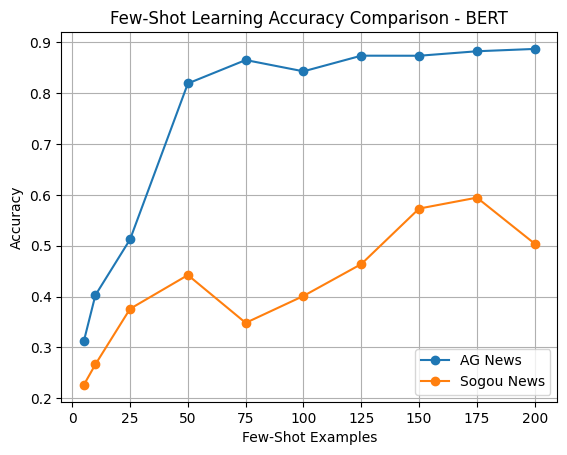

In [ ]:
import matplotlib.pyplot as plt

few_shot_examples = [5, 10, 25, 50, 75, 100, 125, 150, 175, 200]

plt.plot(few_shot_examples, acc_list, label='AG News', marker='o', linestyle='-')
plt.plot(few_shot_examples, acc_list_sg, label='Sogou News', marker='o', linestyle='-')

plt.title('Few-Shot Learning Accuracy Comparison - BERT')
plt.xlabel('Few-Shot Examples')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from datasets import load_dataset
import pandas as pd


def train_bert(dataset):
  # Extract train and test sets
  train_data = dataset['train']
  test_data = dataset['test']

  # Convert datasets to Pandas DataFrame for easier manipulation
  train_df = pd.DataFrame({'text': train_data['text'], 'label': train_data['label']})
  test_df = pd.DataFrame({'text': test_data['text'], 'label': test_data['label']})

  from sklearn.model_selection import train_test_split

  train_df, valid_df = train_test_split(train_df, test_size=0.3, random_state=42)

  # Preprocess the data
  train_df['text'] = train_df['text'].apply(lambda x: str(x))
  test_df['text'] = test_df['text'].apply(lambda x: str(x))
  valid_df['text'] = valid_df['text'].apply(lambda x: str(x))

  # Load pre-trained BERT model and tokenizer
  model_name = 'bert-base-uncased'
  tokenizer = BertTokenizer.from_pretrained(model_name)
  model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(train_df['label'].unique()))

  # Tokenize and format the data with attention_mask
  def tokenize_data(text, max_len=128):
      tokens = tokenizer.encode_plus(text, max_length=max_len, padding='max_length', truncation=True, return_tensors='pt', return_attention_mask=True)
      return tokens

  print('Tokenizing...')
  X_train_tokens = torch.cat([tokenize_data(text)['input_ids'] for text in train_df['text']])
  X_test_tokens = torch.cat([tokenize_data(text)['input_ids'] for text in test_df['text']])
  X_valid_tokens = torch.cat([tokenize_data(text)['input_ids'] for text in valid_df['text']])
  attention_mask_train = torch.cat([tokenize_data(text)['attention_mask'] for text in train_df['text']])
  attention_mask_test = torch.cat([tokenize_data(text)['attention_mask'] for text in test_df['text']])
  attention_mask_valid = torch.cat([tokenize_data(text)['attention_mask'] for text in valid_df['text']])

  # Create DataLoader for training and testing data
  batch_size = 64
  train_dataset = TensorDataset(X_train_tokens, attention_mask_train, torch.tensor(train_df['label'].values))
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  test_dataset = TensorDataset(X_test_tokens, attention_mask_test, torch.tensor(test_df['label'].values))
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  valid_dataset = TensorDataset(X_valid_tokens, attention_mask_valid, torch.tensor(valid_df['label'].values))
  valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

  epochs = 10
  lr = 2e-5

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  print('Training start...')
  optimizer = AdamW(model.parameters(), lr=lr)
  loss_fn = torch.nn.CrossEntropyLoss()

  ct = 0
  best_acc = 0
  acc_train = []
  acc_valid = []
  best_model = model

  for epoch in range(epochs):
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}'):
      model.train()
      inputs, attention_mask, labels = batch
      inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs, attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      total_loss += loss.item()

      loss.backward()
      optimizer.step()

      _, preds = torch.max(outputs.logits, 1)
      acc_train.append(accuracy_score(labels.cpu().numpy(), preds.cpu().numpy()))
      model.eval()
      all_preds = []
      with torch.no_grad():
          for batch in tqdm(valid_dataloader, desc='Evaluating'):
              inputs, attention_mask, labels = batch
              inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

              outputs = model(inputs, attention_mask=attention_mask)
              _, preds = torch.max(outputs.logits, 1)
              all_preds.extend(preds.cpu().numpy())
          # Evaluate the model
      accuracy = accuracy_score(valid_df['label'].values, all_preds)
      acc_valid.append(accuracy)
      if accuracy > best_acc:
        best_acc = accuracy
        best_model = model
        print('saving model with acc {:.2f}'.format(accuracy))

    average_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.4f}')

  # Evaluate the model
  best_model.eval()
  all_preds = []
  with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Evaluating'):
      inputs, attention_mask, labels = batch
      inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

      outputs = best_model(inputs, attention_mask=attention_mask)
      _, preds = torch.max(outputs.logits, 1)
      all_preds.extend(preds.cpu().numpy())

  accuracy = accuracy_score(test_df['label'].values, all_preds)
  print(f'\nTest Accuracy: {accuracy:.2f}')

  # Print classification report
  print('Classification Report:\n', classification_report(test_df['label'].values, all_preds))

  if len(few_shot_dataset['train']) > 10000:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(acc_train)), acc_train, label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(range(len(acc_valid)), acc_valid, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.xticks(range(0,20,1),range(1,21,1))
    best_epoch = acc_valid.index(max(acc_valid))
    best_accuracy = max(acc_valid)
    plt.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
    plt.scatter(best_epoch, best_accuracy, color='red', s=100, label=f'Highest Accuracy: {best_accuracy:.2f}')


    plt.tight_layout()

    plt.show()

  return accuracy

In [ ]:
few_shot_ag_lz4 = [0.6199444444444444, 0.6433333333333334, 0.6972222222222223, 0.735, 0.7558888888888889,
 0.7736111111111111, 0.7872222222222223, 0.7955555555555556, 0.8052777777777779, 0.8094444444444444]
few_shot_sogou_gzip = [0.6494666666666666, 0.6975555555555556, 0.7830666666666667, 0.8172, 0.8493333333333334,
 0.8548, 0.8646666666666667, 0.8710666666666667, 0.8758666666666667, 0.8785333333333334]


few_shot_ag_bert = [0.34921052631578947,
                    0.45092105263157894,
                    0.611578947368421,
                    0.7447368421052631,
                    0.8292105263157895,
                    0.8813157894736842,
                    0.8782894736842105,
                    0.8910526315789473,
                    0.8863157894736842,
                    0.868421052631579]
few_shot_sogou_bert = [0.12, 0.34, 0.28, 0.38, 0.3, 0.36, 0.52, 0.6, 0.62, 0.62]

# lstm - ag
few_shot_acc_ag =[26.080729166666668,
                  23.6328125,
                  27.200520833333336,
                  25.026041666666664,
                  29.075520833333336,
                  25.755208333333336,
                  27.252604166666668,
                  26.692708333333332,
                  27.291666666666664,
                  29.114583333333332]
few_shot_acc_ag = [x / 100 for x in few_shot_acc_ag]

# lstm - sogou
few_shot_acc = [29.156116737739872,
                22.799506929637527,
                33.34055170575693,
                38.43283582089552,
                39.74546908315565,
                57.19616204690831,
                57.93077025586354,
                53.14998667377399,
                67.31909648187633,
                59.384994669509595]
few_shot_acc = [x / 100 for x in few_shot_acc]

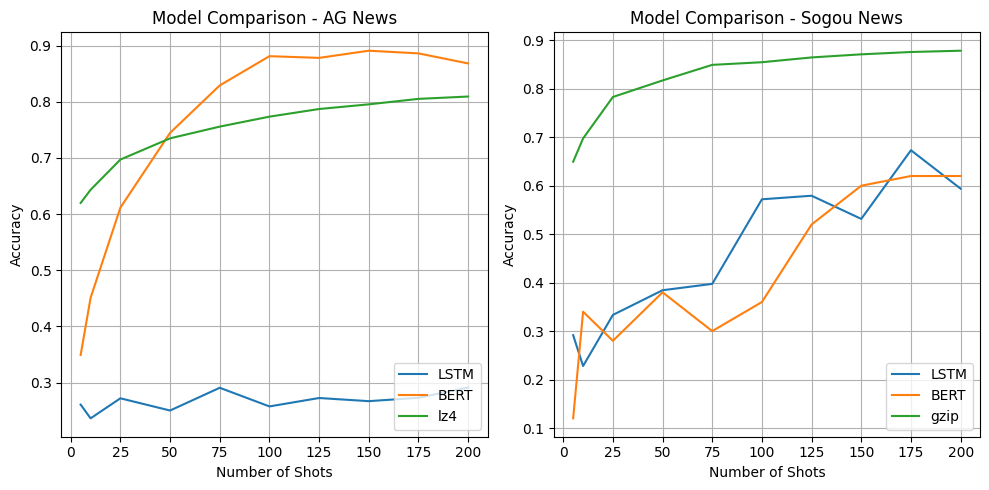

In [ ]:
import matplotlib.pyplot as plt

few_shot_examples = [5, 10, 25, 50, 75, 100, 125, 150, 175, 200]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(few_shot_examples, few_shot_acc_ag, label='LSTM',  linestyle='-')
plt.plot(few_shot_examples, few_shot_ag_bert, label='BERT', linestyle='-')
plt.plot(few_shot_examples, few_shot_ag_lz4, label='lz4',  linestyle='-')
plt.title('Model Comparison - AG News')
plt.xlabel('Number of Shots')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(few_shot_examples, few_shot_acc, label='LSTM', linestyle='-')
plt.plot(few_shot_examples, few_shot_sogou_bert, label='BERT', linestyle='-')
plt.plot(few_shot_examples, few_shot_sogou_gzip, label='gzip', linestyle='-')
plt.title('Model Comparison - Sogou News')
plt.xlabel('Number of Shots')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.grid(True)
plt.tight_layout()

plt.show()